In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
import pyvisa as visa
from rigol_osc import osc_ask_data
import tkinter as tk
from tkinter import filedialog
import csv
import time

In [44]:
# Dedault oscilloscope
sampling_time = 100 #s
memory_depth = "100M"
oscilloscope_address = 'TCPIP0::192.168.1.9::inst0::INSTR'
rm = visa.ResourceManager()
oscilloscope = rm.open_resource(oscilloscope_address)
print(oscilloscope.query('*IDN?'))
oscilloscope.chunk_size = 1024 * 1024
time.sleep(1)
oscilloscope.write(f':ACQ:MDEP {memory_depth}')
oscilloscope.write(f':TIMebase:MAIN:SCALe {sampling_time/10}')
oscilloscope.write(f':TIMebase:MAIN:OFFSet {sampling_time/2}')
oscilloscope.write(':SINGle')
# oscilloscope.close()
sampling_rate = int(float(oscilloscope.query(':ACQuire:SRATe?')))
print(f'Sampling rate: {sampling_rate/1000} kHz')

RIGOL TECHNOLOGIES,MSO5354,MS5A245109692,00.01.03.03.00

Sampling rate: 1000.0 kHz


In [45]:
oscilloscope.write(':TFORce')

9

In [42]:
# Parameters
split_num = 1 # also is average number
window_seg_number = 500 # number of segments in each window 2000
# sampling_rate = 1000000 # Sa/s
zohms = 50

In [6]:
# Get rawdata1
if oscilloscope.query(':TRIGger:STATus?') == 'STOP\n':
    rawdata1 = osc_ask_data([4], memory_depth, time_colume=False) #Squ
signal1 = rawdata1[0] #Squ
split_size = len(signal1) // split_num
signal1_split = np.array_split(signal1[:split_size*split_num], split_num)
# Welch's method for signal1
Pxx_avg_seg1 = []
for i in range(split_num):
    f1, Pxx_avg_seg1_ = welch(signal1_split[i], fs=sampling_rate, window='boxcar', nperseg=len(signal1_split[i])//window_seg_number, noverlap=None, scaling='spectrum')
    """
    window can be one of the following:
        - boxcar
        - triang
        - blackman
        - hamming
        - hann
        - bartlett
        - flattop
        - parzen
        - bohman
        - blackmanharris
        - nuttall
        - barthann
        - cosine
        - exponential
        - tukey
        - taylor
        - lanczos
    When window is boxcar, window_seg_number is 1, and noverlap is None, the result is equivalent to `scipy.signal.periodogram`.
    """
    Pxx_avg_seg1.append(Pxx_avg_seg1_)
Pxx_avg1 = np.mean(Pxx_avg_seg1, axis=0)
Pxx_avg1 = 10 * np.log10(Pxx_avg1 / zohms) + 30

('ASRL1::INSTR', 'ASRL3::INSTR', 'ASRL4::INSTR', 'ASRL5::INSTR')
RIGOL TECHNOLOGIES,MSO5354,MS5A245109692,00.01.03.03.00

Getting data from Channel 4...
OSC operation Done



In [13]:
# Get rawdata2
if oscilloscope.query(':TRIGger:STATus?') == 'STOP\n':
    rawdata2 = osc_ask_data([4], memory_depth, time_colume=False) #Antisqu
signal2 = rawdata2[0] #Antisqu
signal2_split = np.array_split(signal2[:split_size*split_num], split_num)
# Welch's method for signal2
Pxx_avg_seg2 = []
for i in range(split_num):
    f2, Pxx_avg_seg2_ = welch(signal2_split[i], fs=sampling_rate, window='boxcar', nperseg=len(signal2_split[i])//window_seg_number, noverlap=None, scaling='spectrum')
    Pxx_avg_seg2.append(Pxx_avg_seg2_)
Pxx_avg2 = np.mean(Pxx_avg_seg2, axis=0)
Pxx_avg2 = 10 * np.log10(Pxx_avg2 / zohms) + 30

('ASRL1::INSTR', 'ASRL3::INSTR', 'ASRL4::INSTR', 'ASRL5::INSTR')
RIGOL TECHNOLOGIES,MSO5354,MS5A245109692,00.01.03.03.00

Getting data from Channel 4...
OSC operation Done



In [40]:
# Get rawdata3
if oscilloscope.query(':TRIGger:STATus?') == 'STOP\n':
    rawdata3 = osc_ask_data([4], memory_depth, time_colume=False) #SNL
signal3 = rawdata3[0] #SNL
signal3_split = np.array_split(signal3[:split_size*split_num], split_num)
# Welch's method for signal3
Pxx_avg_seg3 = []
for i in range(split_num):
    f3, Pxx_avg_seg3_ = welch(signal3_split[i], fs=sampling_rate, window='boxcar', nperseg=len(signal3_split[i])//window_seg_number, noverlap=None, scaling='spectrum')
    Pxx_avg_seg3.append(Pxx_avg_seg3_)
Pxx_avg3 = np.mean(Pxx_avg_seg3, axis=0)
Pxx_avg3 = 10 * np.log10(Pxx_avg3 / zohms) + 30


('ASRL1::INSTR', 'ASRL3::INSTR', 'ASRL4::INSTR', 'ASRL5::INSTR')
RIGOL TECHNOLOGIES,MSO5354,MS5A245109692,00.01.03.03.00

Getting data from Channel 4...
OSC operation Done



In [7]:
Pxx_avg2 = Pxx_avg1
Pxx_avg3 = Pxx_avg1

Sampling rate: 1000.0 kHz


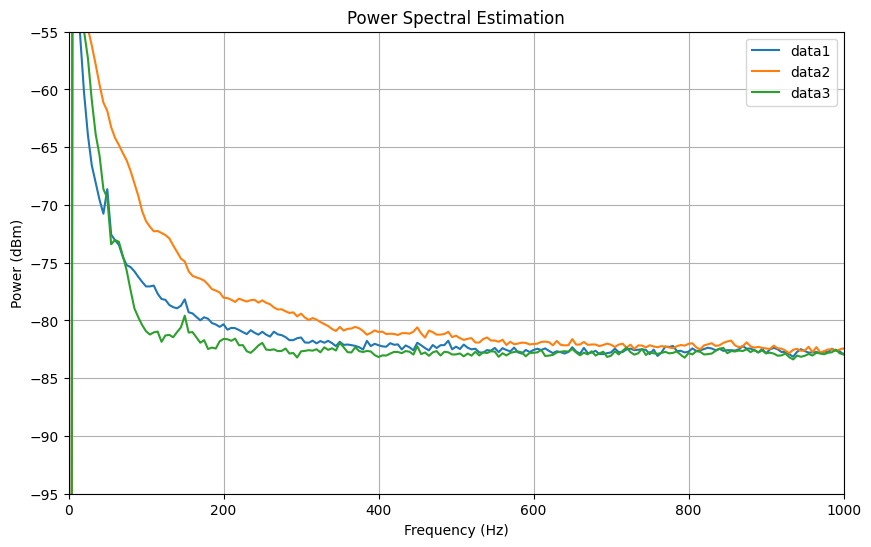

In [43]:
# Plot
print(f'Sampling rate: {sampling_rate/1000} kHz')
yrange = 40
yref = -75
plt.figure(figsize=(10, 6))
plt.plot(f1, Pxx_avg1, label='data1')
plt.plot(f2, Pxx_avg2, label='data2')
plt.plot(f3, Pxx_avg3, label='data3')
plt.title('Power Spectral Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dBm)')
plt.xlim(0,1000)
plt.ylim(yref-yrange/2, yref+yrange/2)
plt.legend()
plt.grid(True)
plt.show()


In [1254]:
dataframe = pd.DataFrame({'Frequency': f1, 'squ(dBm)': Pxx_avg1, 'antisqu(dBm)': Pxx_avg2, 'SNL(dBm)': Pxx_avg3})
# dataframe = pd.DataFrame({'Frequen_cy': f1, 'left': Pxx_avg1, 'right': Pxx_avg2, 'double': Pxx_avg3})
dataframe.to_csv("../data/[3]squ&asqu&snl.csv", index=False, sep=',')

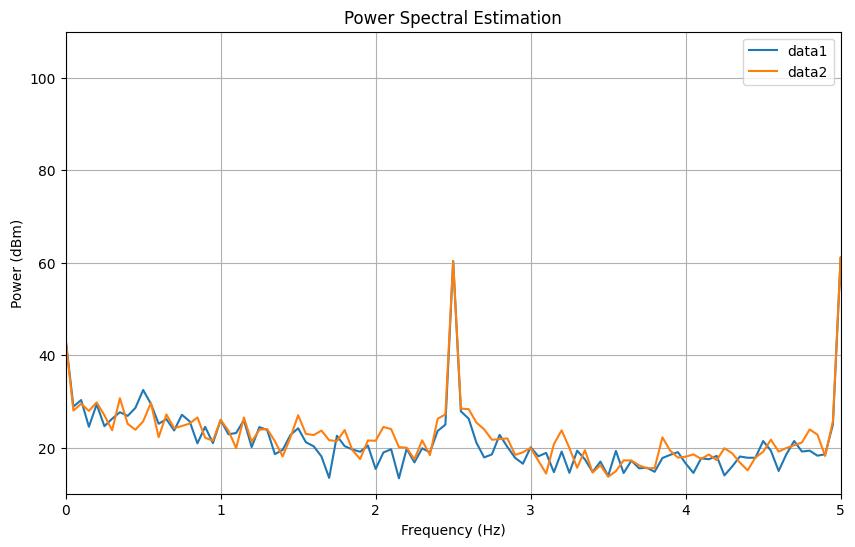

In [355]:
n = len(Pxx_avg1)
Pxx_avg4 = []
Pxx_avg5 = []
for i in range(n):
    num0 = Pxx_avg1[i] - Pxx_avg3[i]
    Pxx_avg4.append(num0)
    num1 = Pxx_avg2[i] - Pxx_avg3[i]
    Pxx_avg5.append(num1)
yrange = 100
yref = 60
plt.figure(figsize=(10, 6))
plt.plot(f1, Pxx_avg4, label='data1')
plt.plot(f2, Pxx_avg5, label='data2')
# plt.plot(f3, Pxx_avg3, label='data3')
plt.title('Power Spectral Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dBm)')
plt.xlim(0,5)
plt.ylim(yref-yrange/2, yref+yrange/2)
plt.legend()
plt.grid(True)
plt.show()

In [356]:
dataframe = pd.DataFrame({'Frequency': f1, 'left-double(dBm)': Pxx_avg4, 'right-double(dBm)': Pxx_avg5})
dataframe.to_csv("../data/[17]_100s_100kSas_AM1Hz_CMRR_AC_coupled.csv", index=False, sep=',')

In [21]:
# Save data
file_name = 'test'
preamble = oscilloscope.query(':WAV:PRE?').split(',')
num_samples = int(preamble[2])
time_per_sample = float(preamble[4])
x_origin = float(preamble[5])
time_array = np.array([x_origin + i * time_per_sample for i in range(num_samples)])
final_data = [time_array]
final_data.append(signal1)
final_data.append(signal2)
final_data.append(signal3)
print('final_data generated. Choose a folder to save the data.')
if file_name:
    # choose a folder to save the data
    root = tk.Tk()
    root.withdraw()  # hide the root window
    folder_path = filedialog.askdirectory()
    # Save waveform data to a CSV file
    print('Writing CSV...')
    BUFFER_SIZE = 1000000  # Adjust the buffer size as needed
    with open(f'{folder_path}/{file_name}_.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Time'] + ['signal1'] + ['signal2'] + ['signal3'])  # Write header
        for row in zip(*final_data):  # Transpose and write
            writer.writerow(row)
    print('CSV writing Done')

final_data generated. Choose a folder to save the data.
Writing CSV...
CSV writing Done


Sampling rate: 1000.0 kHz


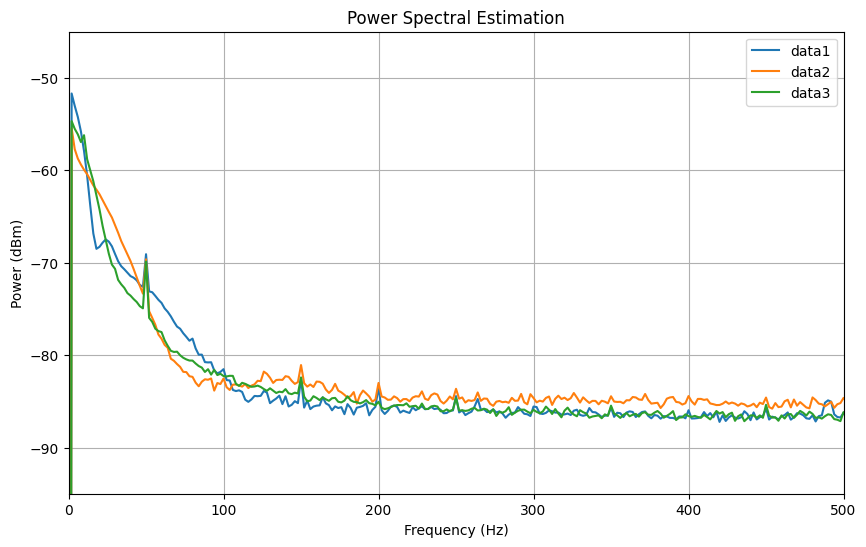

In [895]:
# Plot
header_rows = 0
data1 = pd.read_csv('../data/[1]_100s_1MSas_seg_num200_DCcoupled_squ&antisqu&snl.csv', skiprows=header_rows)
x = data1['Frequency']
y1 = data1['squ(dBm)']
y2 = data1['antisqu(dBm)']
y3 = data1['SNL(dBm)']
print(f'Sampling rate: {sampling_rate/1000} kHz')
yrange = 50
yref = -70
plt.figure(figsize=(10, 6))
plt.plot(x, y1, label='data1')
plt.plot(x, y2, label='data2')
plt.plot(x, y3, label='data3')
plt.title('Power Spectral Estimation')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dBm)')
plt.xlim(0,500)
plt.ylim(yref-yrange/2, yref+yrange/2)
plt.legend()
plt.grid(True)
plt.show()
